In [24]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [25]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [38]:
len(words)
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [39]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [45]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1,b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [46]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,) , generator=g)
    Xb , Yb = Xtr[ix], Ytr[ix] # sample a batch
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i%10000==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.item())

      0/ 200000: 3.3091
  10000/ 200000: 2.4062
  20000/ 200000: 2.2719
  30000/ 200000: 2.0326
  40000/ 200000: 1.9983
  50000/ 200000: 2.4017
  60000/ 200000: 2.2712
  70000/ 200000: 2.0150
  80000/ 200000: 1.9887
  90000/ 200000: 2.0578
 100000/ 200000: 2.4542
 110000/ 200000: 2.1407
 120000/ 200000: 2.0326
 130000/ 200000: 2.3694
 140000/ 200000: 2.1493
 150000/ 200000: 2.3643
 160000/ 200000: 2.0745
 170000/ 200000: 2.0556
 180000/ 200000: 2.1872
 190000/ 200000: 1.8991


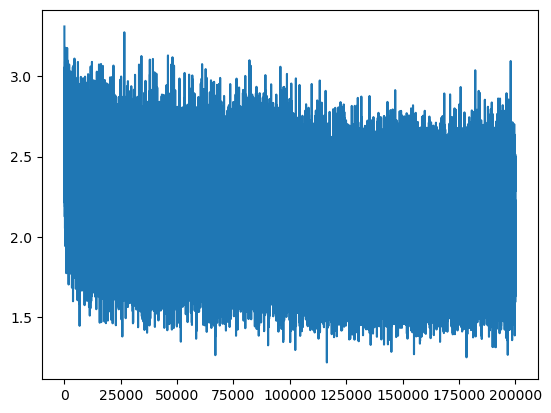

In [47]:
plt.plot(lossi)

In [48]:
@torch.no_grad()
def split_loss(split):
    x , y ={
        'train':(Xtr, Ytr),
        'val':(Xdev, Ydev),
        'test':(Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 2.0343782901763916
val 2.1024086475372314


In [49]:
#Inference 

g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs , num_samples = 1 , generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: break
    print(''.join(itos[i] for i in out))

mora.
mayanniellen.
hayla.
remmadiendra.
gradeeko.
eliah.
milopileigh.
esmanar.
kate.
malaia.
noshubergian.
jest.
jair.
jennex.
terian.
breyce.
rya.
julieh.
yuma.
myshayde.


In [54]:
## Pytorchfiying the code 

from typing import Any


class Linear:

    def __init__(self , fan_in , fan_out , bias = True) -> None:
        self.weight = torch.randn((fan_in , fan_out) , generator= g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self,x) -> Any:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self , dim , eps = 1e-5 , momentum = 0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x) -> Any:
        if self.training:
            xmean = x.mean(0 , keepdim=True)
            xvar = x.var(0 , keepdim =True , unbiased = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) *  self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma , self.beta]
    
class Tanh:
    def __call__(self,x) -> Any:
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size , n_embd) , generator=g)
layers = [
    Linear(n_embd * block_size , n_hidden) , Tanh(),
    Linear(n_hidden , n_hidden) , Tanh(),
    Linear(n_hidden , n_hidden) , Tanh(),
    Linear(n_hidden , n_hidden) , Tanh(),
    Linear(n_hidden , n_hidden) , Tanh(),
    Linear(n_hidden , vocab_size), 
]
with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer , Linear):
            layer.weight*=5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


46497


In [58]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    ix = torch.randint(0 , Xtr.shape[0] , (batch_size,) , generator=g)
    Xb , Yb = Xtr[ix] , Ytr[ix]

    emb = C[Xb]

    x = emb.view(emb.shape[0] , -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x , Yb)

    #backward pass
    for layer in layers:
        layer.out.ratain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i%10000==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.item())
    break

TypeError: 'Linear' object is not iterable